In [19]:
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Read the list of filenames from the configuration file
with open('file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0

# Parse each file
for file in file_names:
    full_path = f"data\\{file}"
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                datalist.append([date, user, message, stream_count])
    stream_count += 1

# Create a DataFrame from parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message", "stream"])
data['date'] = pd.to_datetime(data['date'])
data['first_message'] = data.groupby('user').cumcount().apply(lambda x: 1 if x == 0 else 0)

# Calculate stream-level statistics
stream_stats = data.groupby('stream').agg(
    first_messages=('first_message', 'sum'),
    total_messages=('stream', 'size'),
    unique_chatters=('user', 'nunique')
)

# Calculate stream duration in seconds
stream_stats['stream_length'] = data.groupby('stream')['date'].agg(lambda x: (x.max() - x.min()).total_seconds())
stream_stats['stream_length_hour'] = stream_stats['stream_length'] / 3600

# Load additional statistics from Excel
exelStats = pd.read_excel('DorozeaStreamStats.xlsx', sheet_name='Munkalap1', header=None, names=['stream', 'avg', 'max', 'follow', 'games'], skiprows=1)

# Merge stream statistics with Excel data
stream_stats = pd.merge(stream_stats, exelStats, on='stream', how='right')
stream_stats['hours_watched'] = stream_stats['stream_length_hour'] * stream_stats['avg']

# Sub and gift data extraction
subData = data[data.apply(lambda row: row['user'].lower() in row['message'].lower(), axis=1)]
giftedData = subData[subData['message'].str.contains(' sub ', case=False, na=False)]

# Calculate gifted subs and unique gifters per stream
unique_gifters = giftedData.groupby('stream')['user'].nunique()
stream_stats = pd.merge(stream_stats, unique_gifters.rename('gifters'), on='stream', how='left').fillna(0)

gift_per_stream = giftedData.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, gift_per_stream.rename('gift'), on='stream', how='left').fillna(0)

# Calculate prime subs, and tier subs

primeData = subData[subData['message'].str.contains('Prime', case=False, na=False)]
prime_per_stream = primeData.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, prime_per_stream.rename('prime'), on='stream', how='left').fillna(0)

# Extract tier subs and calculate per stream
trueSub = subData[~subData['message'].str.contains('Prime|raiders|gifting|gifted', case=False)]
trueSub = trueSub[trueSub['message'].str.contains(' subscribed at ', case=False)]

for tier in [1, 2, 3]:
    tier_data = trueSub[trueSub['message'].str.contains(f'Tier {tier}', case=False)]
    tier_per_stream = tier_data.groupby('stream')['user'].count()
    stream_stats = pd.merge(stream_stats, tier_per_stream.rename(f'tier{tier}'), on='stream', how='left').fillna(0)

# Add stream date information
data['date_only'] = data['date'].dt.date
stream_date = data.groupby('stream')['date_only'].min().reset_index().rename(columns={'date_only': 'stream_date'})
stream_stats = pd.merge(stream_stats, stream_date, on='stream', how='left')
stream_stats['stream_date'] = pd.to_datetime(stream_stats['stream_date'])

# Calculate active subs, prime, and tiers in the last 30 days
for col in ['tier1', 'prime', 'tier2', 'tier3', 'gift']:
    active_col = f'active_{col}'
    active_subs = []
    for i in range(len(stream_stats)):
        current_date = stream_stats.iloc[i]['stream_date']
        mask = (stream_stats['stream_date'] <= current_date) & (stream_stats['stream_date'] > current_date - pd.Timedelta(days=30))
        active_count = stream_stats.loc[mask, col].sum()
        active_subs.append(active_count)
    stream_stats[active_col] = active_subs

# Total active subs calculation
stream_stats['all_sub'] = stream_stats[['tier1', 'tier2', 'tier3', 'prime', 'gift']].sum(axis=1)

# Cumulative watch hours
initial_watch_hours = 97068
stream_stats['watch_hour'] = stream_stats['hours_watched'].cumsum() + initial_watch_hours

# Add ad revenue (e.g., $0.72 per 100 hours watched)
stream_stats['ad_rev'] = stream_stats['hours_watched'] * 0.72 / 100

# Time since first stream
stream_stats['days_since_first_stream'] = (stream_stats['stream_date'] - stream_stats['stream_date'].min()).dt.days

# Linear regression to predict average viewers reaching 500
X = stream_stats[['days_since_first_stream']]
y = stream_stats['avg']
model = LinearRegression().fit(X, y)
target_viewers = 500
predicted_days = (target_viewers - model.intercept_) / model.coef_[0]
predicted_date = stream_stats['stream_date'].min() + pd.to_timedelta(predicted_days, unit='d')
print(f"Expected to reach {target_viewers} average viewers on: {predicted_date.date()}")

# Linear regression to predict 300 active subs (tier1 + prime)
stream_stats_no_may = stream_stats[stream_stats['stream_date'] > '2024-05-31'].copy()
X = stream_stats_no_may[['days_since_first_stream']]
y = stream_stats_no_may['active_tier1'] + stream_stats_no_may['active_prime']
model = LinearRegression().fit(X, y)
target_active_subs = 300
predicted_days = (target_active_subs - model.intercept_) / model.coef_[0]
predicted_date = stream_stats_no_may['stream_date'].min() + pd.to_timedelta(predicted_days, unit='d')
print(f"Expected to reach {target_active_subs} active tier 1 & prime subs on: {predicted_date.date()}")

# Polynomial regression to predict 5M watch hours
X = stream_stats[['days_since_first_stream']]
y = stream_stats['watch_hour']
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
model_poly = LinearRegression().fit(X_poly, y)

# Solve quadratic equation for 5M watch hours
target_hours = 5000000
beta_0, beta_1, beta_2 = model_poly.intercept_, model_poly.coef_[1], model_poly.coef_[2]
discriminant = beta_1**2 - 4*beta_2*(beta_0 - target_hours)

if discriminant >= 0:
    predicted_days_1 = (-beta_1 + np.sqrt(discriminant)) / (2 * beta_2)
    predicted_days_2 = (-beta_1 - np.sqrt(discriminant)) / (2 * beta_2)
    predicted_days = max(predicted_days_1, predicted_days_2)
    predicted_date = stream_stats['stream_date'].min() + pd.to_timedelta(predicted_days, unit='d')
    print(f"Expected to reach {target_hours} watch hours on: {predicted_date.date()}")
else:
    print("No real solution found.")


Expected to reach 500 average viewers on: 2025-08-22
Expected to reach 300 active tier 1 & prime subs on: 2025-06-20
Expected to reach 5000000 watch hours on: 2030-12-02


In 2024 09 09

Expected to reach 500 average viewers on: 2025-08-22 \
Expected to reach 300 active tier 1 & prime subs on: 2025-06-20 \
Expected to reach 5000000 watch hours on: 2030-12-02

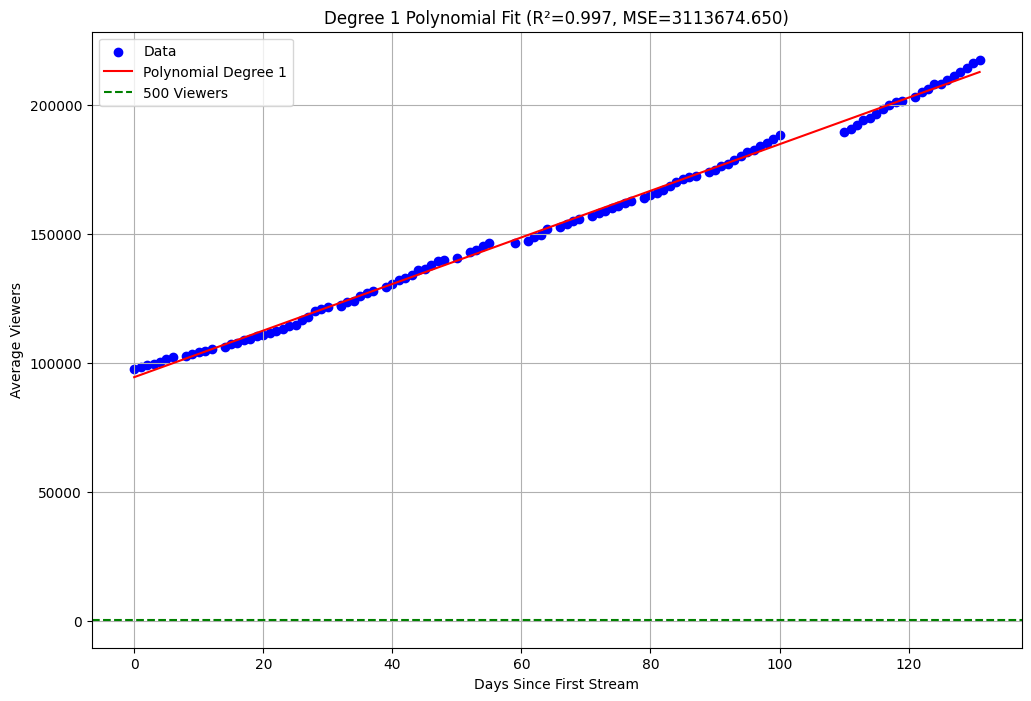

Degree 1 Polynomial: R² = 0.997, MSE = 3113674.650


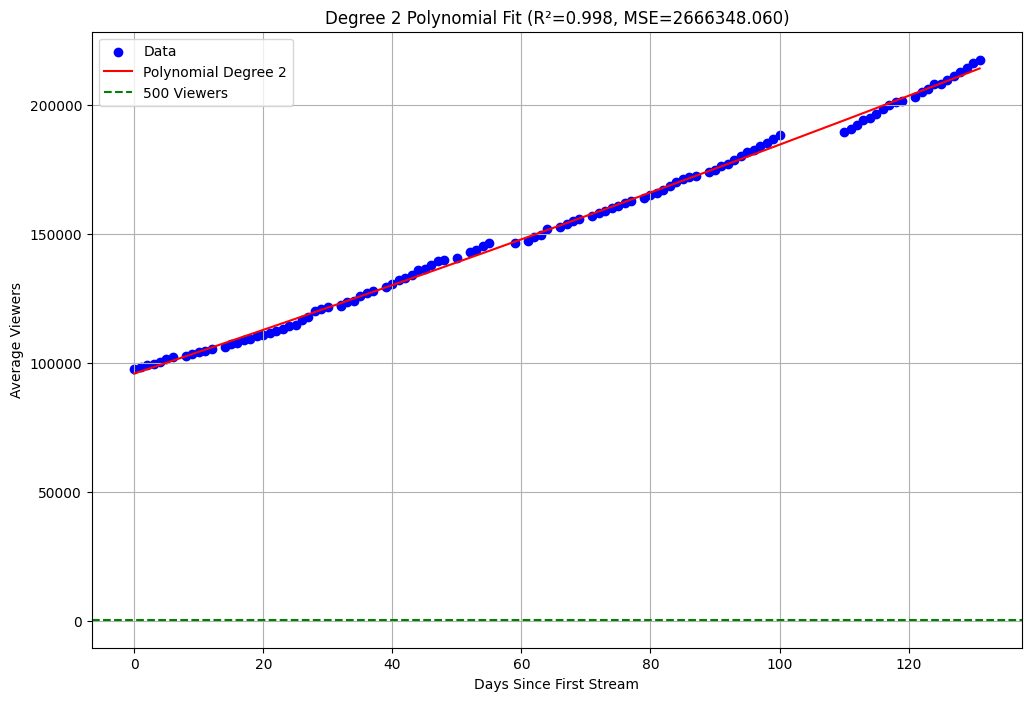

Degree 2 Polynomial: R² = 0.998, MSE = 2666348.060


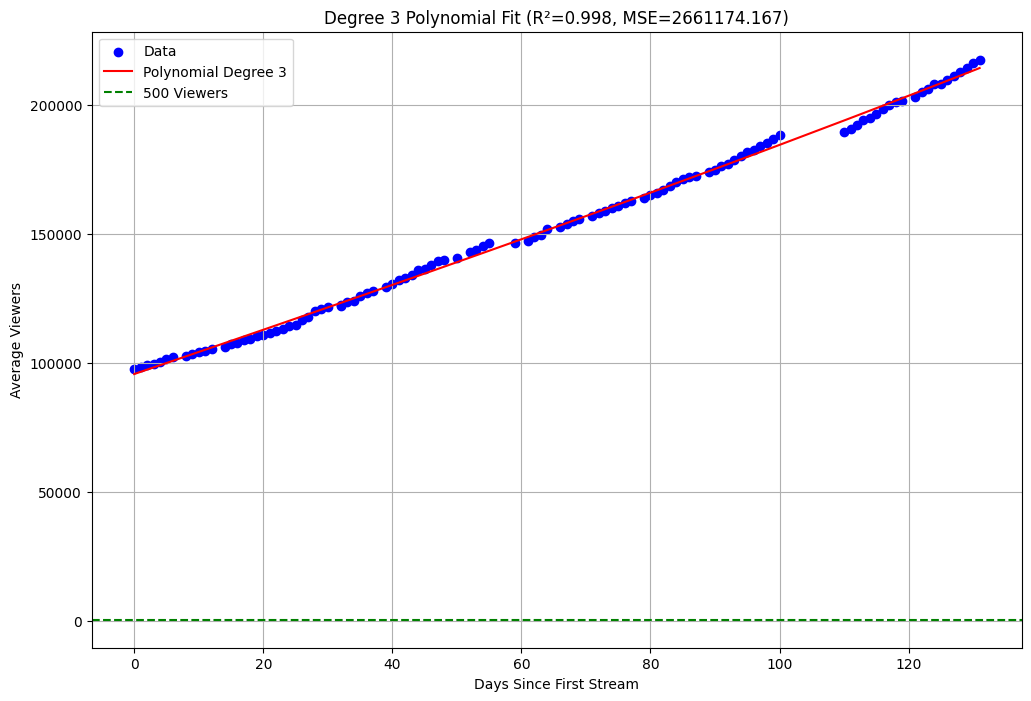

Degree 3 Polynomial: R² = 0.998, MSE = 2661174.167
Degree 1 Polynomial - Average R² from 5-Fold Cross-Validation: 0.916
Degree 2 Polynomial - Average R² from 5-Fold Cross-Validation: 0.917
Degree 3 Polynomial - Average R² from 5-Fold Cross-Validation: 0.593


In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

# Create a function to fit polynomial regression and evaluate performance
def fit_polynomial(degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, y)
    
    y_pred = model.predict(X_poly)
    
    # Calculate R² and MSE
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    
    # Plot the polynomial regression curve
    plt.figure(figsize=(12, 8))
    plt.scatter(X, y, color='blue', label='Data')
    plt.plot(X, y_pred, color='red', label=f'Polynomial Degree {degree}')
    plt.axhline(y=500, color='green', linestyle='--', label='500 Viewers')
    plt.legend()
    plt.xlabel('Days Since First Stream')
    plt.ylabel('Average Viewers')
    plt.title(f'Degree {degree} Polynomial Fit (R²={r2:.3f}, MSE={mse:.3f})')
    plt.grid(True)
    plt.show()
    
    return r2, mse

# Try polynomial degrees 2 and 3 to find the best fit
for degree in [1, 2, 3]:
    r2, mse = fit_polynomial(degree)
    print(f'Degree {degree} Polynomial: R² = {r2:.3f}, MSE = {mse:.3f}') 

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Create a function to perform k-fold cross-validation for a given polynomial degree
def cross_val_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    
    # Perform 5-fold cross-validation and get the average R² score
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')  # or scoring='neg_mean_squared_error'
    return scores.mean()

# Test for polynomial degrees 1 to 3
for degree in range(1, 4):
    avg_r2 = cross_val_poly(degree)
    print(f'Degree {degree} Polynomial - Average R² from 5-Fold Cross-Validation: {avg_r2:.3f}')